## Head

In [1]:
import os
import sys
import pandas as pd
import dask.dataframe as dd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
import importlib
from typing import List, Dict, Union
import lightgbm as lgb

In [2]:
import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.rlearner as rlearner

- The price of 1 g of the product is equal to 80 coins. The cost of production is equal to 52 coins
- Sending one message costs 1 coin
- A customer does not buy more than once a day

## Lib

In [8]:
import sys
sys.path.append('../')
import featurelib as fl

In [9]:
def dask_groupby(
    data: dd.DataFrame,
    by: List[str],
    config: Dict[str, Union[str, List[str]]]
) -> dd.DataFrame:
    data_ = data.copy()
    dask_agg_config = dict()

    for col, aggs in config.items():
        aggs = aggs if isinstance(aggs, list) else [aggs]
        for agg in aggs:
            fictious_col = f'{col}_{agg}'
            data_ = data_.assign(**{fictious_col: lambda d: d[col]})
            dask_agg_config[fictious_col] = agg

    result = data_.groupby(by=by).agg(dask_agg_config)
    return result


In [10]:
class ReceiptsBasicFeatureCalcer(fl.DateFeatureCalcer):
    name = 'receipts_basic'
    keys = ['customer_id']

    def __init__(self, delta: int, **kwargs):
        self.delta = delta
        super().__init__(**kwargs)

    def compute(self) -> dd.DataFrame:
        receipts = self.engine.get_table('receipts')
        
        date_from = self.date_to - self.delta
        date_mask = (receipts['date'] >= date_from) & (receipts['date'] < self.date_to)

        features = receipts.loc[date_mask]
        features = dask_groupby(
            features,
            by=['customer_id'],
            config={
                "purchase_sum": ["sum", "max", "min", "mean"],
                "discount": ["sum"],
                "date": ["min", "max", "count"],
            }
        )
        features = (
            features
            .assign(
                mean_time_interval=lambda d: (
                    (d['date_max'] - d['date_min']) / (d['date_count'] - 1)
                )
            )
            .assign(time_since_last=lambda d: self.date_to - d['date_max'])
        )

        features = features.reset_index()
        features = features.rename(columns={
            col: col + f'__{self.delta}d' for col in features.columns if col not in self.keys
        })

        return features

In [11]:
class AgeGeoCalcer(fl.FeatureCalcer):
    name = 'age_geo'
    keys = ['customer_id']

    def compute(self) -> dd.DataFrame:
        customers_info = self.engine.get_table('customers')
        return customers_info[self.keys + ['age', 'location']]

In [12]:
class CampaignInfoCalcer(fl.DateFeatureCalcer):
    name = 'campaigns_info'
    keys = ['customer_id']
    
    def compute(self) -> dd.DataFrame:
        campaigns = self.engine.get_table('campaigns')
        date_mask = campaigns['date'] == self.date_to

        result = (
            self.engine.get_table('campaigns')
            .loc[date_mask]
            [[
                'customer_id',
                'n_offer_days', 'target_group_flag', 'date'
            ]]
            .rename(columns={'date': 'campaign_date'})
        )
        return result


In [13]:
fl.register_calcer(ReceiptsBasicFeatureCalcer)
fl.register_calcer(AgeGeoCalcer)
fl.register_calcer(CampaignInfoCalcer)

## Load'n'cook

In [3]:
engine = fl.Engine(tables={
    'receipts': dd.read_parquet('data/receipts.parquet', engine='pyarrow'),
    'customers': dd.read_csv('data/customers.csv'),
    'campaigns': dd.read_csv('data/campaigns.csv'),
})

### train

#### load

In [15]:
calcers_config = [
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 5
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 15
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 50
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 100
        }
    },
    { # target period
        'name': 'receipts_basic',
        'args': {
            'date_to': 132, 'delta': 30
        }
    },
    { # offer period
        'name': 'receipts_basic',
        'args': {
            'date_to': 109, 'delta': 7
        }
    },
    {
        'name': 'age_geo',
        'args': {}
    },
    {
        'name': 'campaigns_info',
        'args': {'date_to': 102}
    }
]

In [16]:
raw_data_train = fl.compute_features(engine, features_config=calcers_config)

In [17]:
raw_data_train = raw_data_train.compute()

In [18]:
raw_data_train.shape

(2000000, 66)

#### transform

In [19]:
def fix_column_names(data: pd.DataFrame) -> pd.DataFrame:
    for _days in [30, 7]:
        for col_name in [
            f'purchase_sum_sum__{_days}d',
            f'purchase_sum_max__{_days}d',
            f'purchase_sum_min__{_days}d',
            f'purchase_sum_mean__{_days}d',
            f'discount_sum__{_days}d',
            f'date_min__{_days}d',
            f'date_max__{_days}d',
            f'date_count__{_days}d',
            f'mean_time_interval__{_days}d',
            f'time_since_last__{_days}d'
        ]:
            data = data.rename(columns={col_name: 'target__' + col_name})
    return data

In [20]:
MARGIN_RATE = 0.35
MESSAGE_COST = 1.0


def _transform(data: pd.DataFrame) -> pd.DataFrame:
    data.fillna({'target_group_flag': 0}, inplace=True)
    data['target_profit'] = (
        MARGIN_RATE * data['target__purchase_sum_sum__30d'].fillna(0.0)
        - MESSAGE_COST * data['target_group_flag'].fillna(0)
        - data['target__discount_sum__30d'].fillna(0)
    )
    return data

In [21]:
data_train = fix_column_names(raw_data_train)
data_train = _transform(data_train)

In [22]:
data_train.head()

,customer_id,purchase_sum_sum__5d,purchase_sum_max__5d,purchase_sum_min__5d,purchase_sum_mean__5d,discount_sum__5d,date_min__5d,date_max__5d,date_count__5d,mean_time_interval__5d,...,target__date_max__7d,target__date_count__7d,target__mean_time_interval__7d,target__time_since_last__7d,age,location,n_offer_days,target_group_flag,campaign_date,target_profit
0,2,3130.691978,2749.047367,381.644612,1565.345989,0.0,97.0,100.0,2.0,3.0,...,NaN,NaN,NaN,NaN,41,Hindarsfjall,7.0,1.0,102.0,1468.691792
1,6,958.400150,958.400150,958.400150,958.400150,0.0,101.0,101.0,1.0,NaN,...,NaN,NaN,NaN,NaN,57,Hindarsfjall,7.0,1.0,102.0,480.967047
2,7,777.908251,777.908251,777.908251,777.908251,0.0,99.0,99.0,1.0,NaN,...,103.0,1.0,NaN,6.0,22,Hindarsfjall,7.0,1.0,102.0,859.641173
3,11,1487.705672,1487.705672,1487.705672,1487.705672,0.0,100.0,100.0,1.0,NaN,...,NaN,NaN,NaN,NaN,57,Novigrad,7.0,1.0,102.0,753.619862
4,13,1079.160515,1079.160515,1079.160515,1079.160515,0.0,101.0,101.0,1.0,NaN,...,NaN,NaN,NaN,NaN,63,Kaer_Trolde,7.0,1.0,102.0,-1.000000


#### splits

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
fit_index, val_index = train_test_split(data_train.index, test_size=0.5, random_state=165)

### serve

#### load

In [25]:
calcers_config = [
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 5
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 15
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 50
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 100
        }
    },
#     { # target period
#         'name': 'receipts_basic',
#         'args': {
#             'date_to': 132, 'delta': 30
#         }
#     },
#     { # offer period
#         'name': 'receipts_basic',
#         'args': {
#             'date_to': 109, 'delta': 7
#         }
#     },
    {
        'name': 'age_geo',
        'args': {}
    },
#     {
#         'name': 'campaigns_info',
#         'args': {'date_to': 102}
#     }
]

In [26]:
raw_data_serve = fl.compute_features(engine, features_config=calcers_config)

In [27]:
raw_data_serve = raw_data_serve.compute()

In [28]:
raw_data_serve.shape

(2000000, 43)

#### transform

In [29]:
data_serve = fix_column_names(raw_data_serve)

### column sets

In [30]:
cols_features_n1 = [
    'date_count__100d',
    'purchase_sum_sum__100d',
    'purchase_sum_max__100d',
    'purchase_sum_min__100d',
    'purchase_sum_mean__100d',
    'mean_time_interval__100d',
    'time_since_last__100d',
    'date_count__5d',
    'purchase_sum_sum__5d',
    'purchase_sum_max__5d',
    'purchase_sum_min__5d',
    'purchase_sum_mean__5d',
    'mean_time_interval__5d',
    'age'
]

In [31]:
data_serve

,customer_id,purchase_sum_sum__5d,purchase_sum_max__5d,purchase_sum_min__5d,purchase_sum_mean__5d,discount_sum__5d,date_min__5d,date_max__5d,date_count__5d,mean_time_interval__5d,...,purchase_sum_min__100d,purchase_sum_mean__100d,discount_sum__100d,date_min__100d,date_max__100d,date_count__100d,mean_time_interval__100d,time_since_last__100d,age,location
0,1,841.402345,841.402345,841.402345,841.402345,0.0,245.0,245.0,1.0,NaN,...,676.339522,942.989648,0.0,157.0,245.0,5.0,22.000000,5.0,53,Hindarsfjall
1,2,2745.248532,2745.248532,2745.248532,2745.248532,0.0,246.0,246.0,1.0,NaN,...,1940.561015,2706.896078,0.0,172.0,246.0,7.0,12.333333,4.0,41,Hindarsfjall
2,6,949.027995,949.027995,949.027995,949.027995,0.0,245.0,245.0,1.0,NaN,...,478.944819,919.874613,0.0,158.0,245.0,8.0,12.428571,5.0,57,Hindarsfjall
3,9,2181.297251,2181.297251,2181.297251,2181.297251,0.0,249.0,249.0,1.0,NaN,...,1697.679759,2023.712759,0.0,193.0,249.0,3.0,28.000000,1.0,29,Novigrad
4,22,1131.647748,1131.647748,1131.647748,1131.647748,0.0,248.0,248.0,1.0,NaN,...,236.225561,962.099677,0.0,150.0,248.0,13.0,8.166667,2.0,36,Hindarsfjall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,Kaer_Trolde
1999996,1999893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,Kaer_Trolde
1999997,1999904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,Oxenfurt
1999998,1999948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,Beauclair


## Main

### EDA

In [32]:
data_train.loc[fit_index].groupby(by=['target_group_flag']).agg({
    'target_profit': 'mean',
    'target__purchase_sum_sum__30d': 'mean',
    'target__discount_sum__30d': 'mean',
    'customer_id': 'count',
})

,target_profit,target__purchase_sum_sum__30d,target__discount_sum__30d,customer_id
target_group_flag,,,,
0.0,877.42898,3085.956567,0.000000,750708
1.0,874.89113,3084.030186,21.925679,249292


In [33]:
data_train.stb.missing()

,missing,total,percent
mean_time_interval__5d,1970933,2000000,98.54665
target__mean_time_interval__7d,1922763,2000000,96.13815
n_offer_days,1500000,2000000,75.00000
campaign_date,1500000,2000000,75.00000
mean_time_interval__15d,1499398,2000000,74.96990
...,...,...,...
target_group_flag,0,2000000,0.00000
customer_id,0,2000000,0.00000
location,0,2000000,0.00000
age,0,2000000,0.00000


In [ ]:
data_train

### model

In [38]:
col_target = 'target_profit'
col_treatment = 'target_group_flag'

In [39]:
cols_features = cols_features_n1

In [40]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [41]:
len(fit_index)

1000000

In [42]:
_p_score_const = data_train.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_n1.fit(
    X=data_train.iloc[fit_index].loc[:,cols_features].fillna(0).values,
    treatment=data_train.iloc[fit_index].loc[:,col_treatment].values,
    y=data_train.iloc[fit_index].loc[:,col_target].values,
    p=_p_scores
)

#### evaluate model

In [43]:
_eval_data = data_train.iloc[val_index].loc[:, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

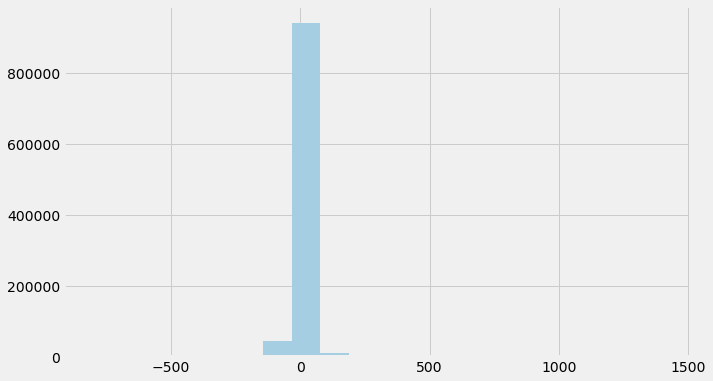

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=20)
plt.show()

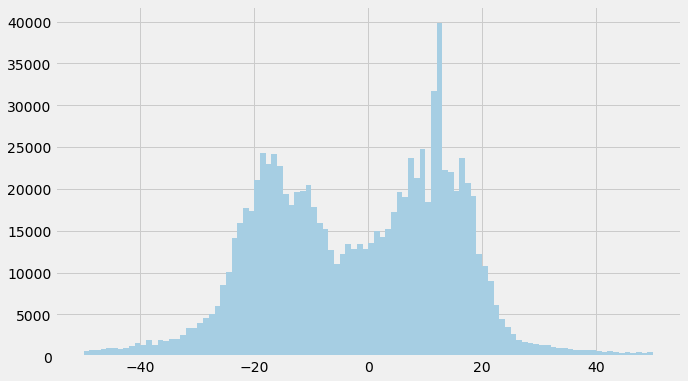

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=100, range=(-50, 50))
plt.show()

In [46]:
np.percentile(_eval_data['score'], 5)

-31.719384391051946

In [47]:
np.percentile(_eval_data['score'], 95)

23.170024412933266

In [48]:
_eval_data['score'].describe()

count    1000000.000000
mean          -1.981109
std           31.332788
min         -802.790302
25%          -16.126859
50%           -0.692813
75%           12.265208
max         1398.041739
Name: score, dtype: float64

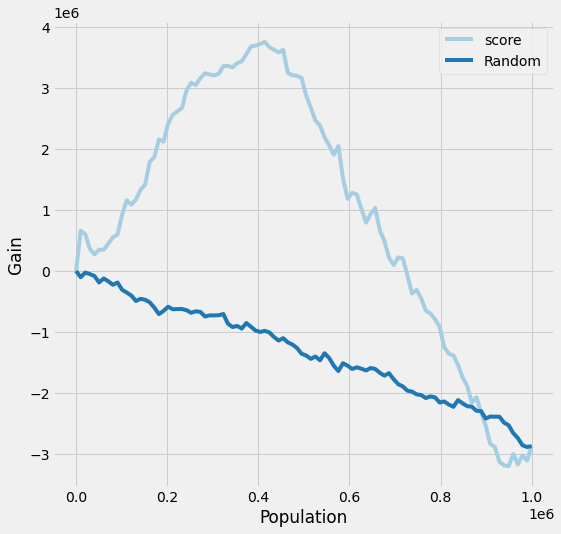

In [49]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

### decisions

In [50]:
data_serve['model_n1_pred'] = model_n1.predict(data_serve[cols_features_n1])

In [51]:
data_serve['model_n1_pred'].describe()

count    2.000000e+06
mean    -1.997854e+00
std      3.133558e+01
min     -9.362994e+02
25%     -1.612686e+01
50%     -7.660856e-01
75%      1.226521e+01
max      1.423888e+03
Name: model_n1_pred, dtype: float64

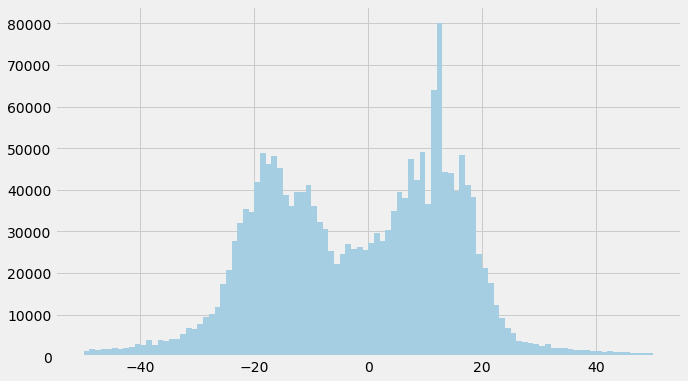

In [52]:
plt.figure(figsize=(10, 6))
plt.hist(data_serve['model_n1_pred'], bins=100, range=(-50, 50))
plt.show()

In [53]:
(data_serve['model_n1_pred'] > 5.0).mean()

0.4151065

In [55]:
data_serve[data_serve['model_n1_pred'] > 5.1]['customer_id'].to_csv('submission.csv', index=None)

In [56]:
sample = data_serve[data_serve['model_n1_pred'] > 5.0]

In [4]:
sample['uplift'] = np.random.choice([0, 1], sample.shape[0])

In [58]:
sample['uplift'].value_counts()

1    415778
0    414435
Name: uplift, dtype: int64

In [59]:
mask = (sample['uplift'] == 1)

In [61]:
sample.columns

Index(['customer_id', 'purchase_sum_sum__5d', 'purchase_sum_max__5d',
       'purchase_sum_min__5d', 'purchase_sum_mean__5d', 'discount_sum__5d',
       'date_min__5d', 'date_max__5d', 'date_count__5d',
       'mean_time_interval__5d', 'time_since_last__5d',
       'purchase_sum_sum__15d', 'purchase_sum_max__15d',
       'purchase_sum_min__15d', 'purchase_sum_mean__15d', 'discount_sum__15d',
       'date_min__15d', 'date_max__15d', 'date_count__15d',
       'mean_time_interval__15d', 'time_since_last__15d',
       'purchase_sum_sum__50d', 'purchase_sum_max__50d',
       'purchase_sum_min__50d', 'purchase_sum_mean__50d', 'discount_sum__50d',
       'date_min__50d', 'date_max__50d', 'date_count__50d',
       'mean_time_interval__50d', 'time_since_last__50d',
       'purchase_sum_sum__100d', 'purchase_sum_max__100d',
       'purchase_sum_min__100d', 'purchase_sum_mean__100d',
       'discount_sum__100d', 'date_min__100d', 'date_max__100d',
       'date_count__100d', 'mean_time_interval__1

In [63]:
profit = (
            (
            sample[mask]['purchase_sum_sum__15d'].sum()*MARGIN_RATE / len(sample[mask]) -
            sample[~mask]['purchase_sum_sum__15d'].sum()*MARGIN_RATE/ len(sample[~mask]) 
            ) * len(sample[mask])
            - sample['discount_sum__15d'].sum() - len(sample[mask]) * 1
         ) * (     
            (len(sample[mask]) + len(sample[~mask])) / len(sample[mask])
              )
profit

-228257.0462614148

In [ ]:
data_serve[d['model_n1_pred'] > 5.1]['target_profit'].sum()